# Quantitative Momentum Strategy

Momentum investing is a trading strategy that focuses on buying assets that have shown strong recent performance and selling those that have performed poorly. The core idea is that "winners keep winning" and "losers keep losing" in the short to medium term.

### Importing libraries

In [11]:
!pip install yfinance pandas numpy requests

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests

### Fetch S&P 500 tickers from Wikipedia & Extractring tickers

In [22]:
# Step 2: Fetch S&P 500 tickers from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(url)
tables = pd.read_html(response.text)
sp500_table = tables[0]  # The first table contains the S&P 500 tickers

# Extract the tickers
tickers = sp500_table['Symbol'].tolist()
print(f"Number of S&P 500 tickers: {len(tickers)}")
print(tickers[:10])  # Print first 10 tickers as a sample

Number of S&P 500 tickers: 503
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


<ipython-input-22-504961a512f9>:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


### Fetch historical stock data for S&P 500 tickers

In [23]:
chunk_size = 50
data = pd.DataFrame()

for i in range(0, len(tickers), chunk_size):
    chunk = tickers[i:i + chunk_size]
    chunk_data = yf.download(chunk, start=start_date, end=end_date, group_by='ticker')

    # Extract 'Close' prices from the multi-index columns
    close_prices = chunk_data.xs('Close', level=1, axis=1)  # Fix here
    data = pd.concat([data, close_prices], axis=1)

[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2024-02-11 17:34:23.834513 -> 2025-02-10 17:34:23.834513)')
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 complete

### Calculate momentum & Rank stocks accordingly

In [24]:
# Step 5: Calculate momentum (6-month and 12-month returns)
returns_6m = data.pct_change(periods=126)  # 6 months = ~126 trading days
returns_12m = data.pct_change(periods=252)  # 12 months = ~252 trading days

# Combine 6-month and 12-month returns into a single momentum metric
momentum = (returns_6m + returns_12m) / 2  # Simple average of both returns

# Step 6: Rank stocks based on momentum
momentum_rank = momentum.iloc[-1].sort_values(ascending=False)  # Use the most recent momentum values
print("Momentum Rankings:")
print(momentum_rank.head(10))  # Print top 10 stocks

<ipython-input-24-fa82e4bc5108>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_6m = data.pct_change(periods=126)  # 6 months = ~126 trading days


Momentum Rankings:
Ticker
AMGN    NaN
A       NaN
APO     NaN
GOOGL   NaN
AMCR    NaN
ACGL    NaN
ALLE    NaN
AEP     NaN
ANET    NaN
AMAT    NaN
Name: 2025-02-10 00:00:00, dtype: float64


<ipython-input-24-fa82e4bc5108>:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_12m = data.pct_change(periods=252)  # 12 months = ~252 trading days


### Select top N stocks for the portfolio & calculate performance

- NOte: equal-weighted portfolio returns and cumulative performance.

In [25]:
top_n = 10  # Number of stocks to include in the portfolio
top_stocks = momentum_rank.head(top_n).index.tolist()
print(f"\nTop {top_n} Stocks for Momentum Strategy:")
print(top_stocks)

#portfolio performance
portfolio_returns = data[top_stocks].pct_change().mean(axis=1)  # Equal-weighted portfolio
cumulative_returns = (1 + portfolio_returns).cumprod() - 1


Top 10 Stocks for Momentum Strategy:
['AMGN', 'A', 'APO', 'GOOGL', 'AMCR', 'ACGL', 'ALLE', 'AEP', 'ANET', 'AMAT']


### Ploting cumulative returns


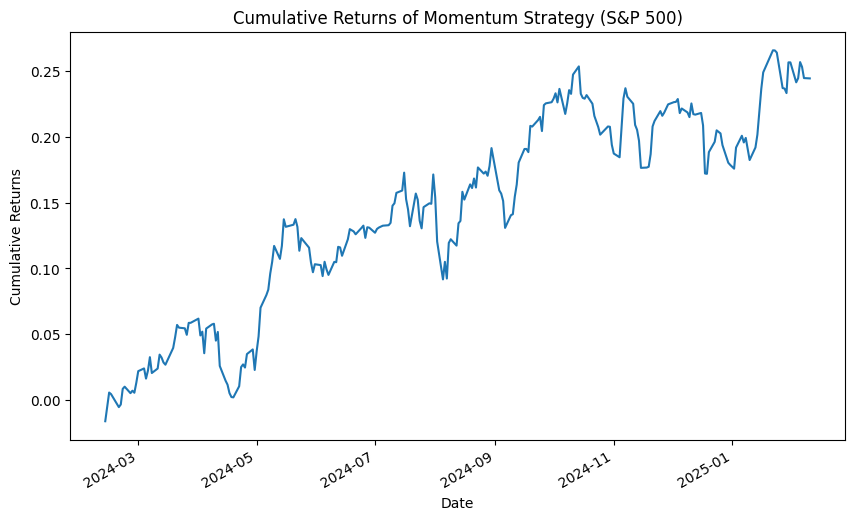

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
cumulative_returns.plot(title="Cumulative Returns of Momentum Strategy (S&P 500)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.show()